# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# Problem Statement

* We will be exploring the Starbuck’s Dataset which simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. 
* There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a required amount that the user is expected to spend. Offers can be delivered via multiple channels.
* We will aim to find an answer to the following questions in this notebook.
 1. What is the proportion of client who have completed the offers based on Gender?
 2. What is the proportion of client who have completed the offers based on their Age?
 3. What is the proportion of client who have completed the offers based on their Income Level?
 3. What are the most important features that help drive the offers in customers?
 


## Strategy 

* First, I will wrangle and combine the data from offer portfolio, customer profile, and transaction. After which I can merge all the table into one for analysis.
* Secondly, I will work on visualization to provide answers to the questions 1 and 2.
* Finally, I will move on to find the important feature driver for the offers. I plan to test out few models(like, Decision Tree Classifier, Gaussian NB and Random Forest Classifier) before applying one as a fixed solution and provide visualization for the important feature drivers.


## Metrics
I will use accuracy and F-score metrics for comparision and to test out the performance of the models.   
Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".

## Table of Contents
* ### [Table Exploration(Portfolio, Profile, Transcript)](#tableexp)
* ### [Data Cleaning for Tables](#dataclean)
* ### [Preparing Table for analysis](#preptable)
* ### [Data Exploration](#dataexp)
* ### [Evaluating Model](#evmodel)
* ### [Conclusion](#conclusion)

  

## Importing

In [3]:
import sys
!{sys.executable} -m pip install progressbar 

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [5]:
print(sys.version)

3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [4]:
import pandas as pd
import numpy as np
import progressbar
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from time import time
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

In [6]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

<a name="tableexp"></a>
# <span style="color:blue"> Table Exploration (Portfolio, Profile, Transcript)</span>

## Portfolio

In [10]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [11]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


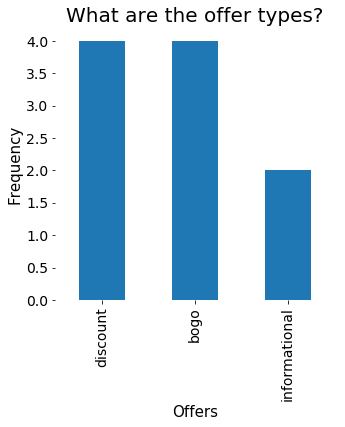

In [14]:
ax = portfolio["offer_type"].value_counts().plot.bar(
    figsize=(5,5),
    fontsize=14,

)

ax.set_title("What are the offer types?", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

We can see from above that the portfolio table consists of 10 not-null entries  that contains information about the offers provided by starbucks. It has channels through which the specific offers are deployed which consists of elements in a list, which has to be handled later in the process.   
Finally, We can see a histogram containing a distribution of 3 offer types totalling in 10 entries.   
This table needs to be cleaned, which will be done in the next phase.

## Profile

In [15]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


---

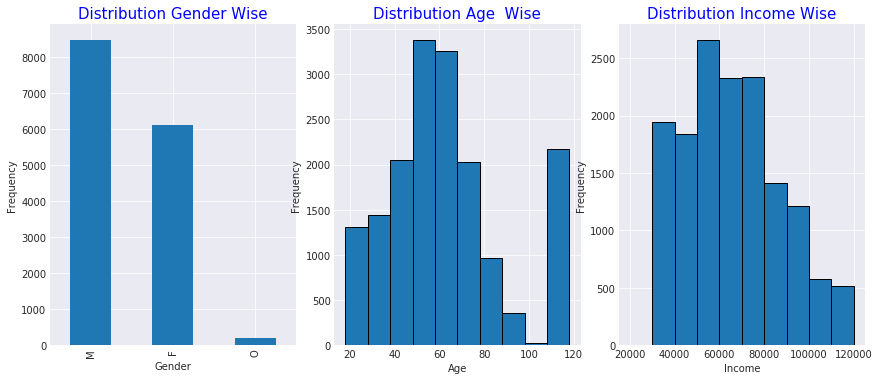

In [58]:
#Creating Subplots for distribution based on Gender,Age and Income
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# GENDER BASED
profile.gender.value_counts().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Distribution Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
profile.age.plot.hist(ax=ax[1],fontsize=10,edgecolor='black') 
ax[1].set_title("Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
profile.income.plot.hist(ax=ax[2],fontsize=10,edgecolor='black',range=(20000, 120000)) 
ax[2].set_title("Distribution Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()


We can see from above that the profile table consists of 17000 entries with some null elements in the columns gender and income.   
Also, from the dashboard above we can see the distribution of the members according to the gender, age and income.   
We can also see that in respect to the distribution according to the gender, frequency of male is more than the female with little population towards others.   
Secondly, while looking at age wise distribution it is evident that the age group from 50-70 is the highest.   
Finally, while looking at the income wise distribution, member with income ranging from 40k- 80k  are high than others.
We need to clean this profile table as it contains nll values as well as age value oof 118 which has a  lot of frequency and it is due to some data entry error. 

## Transcript 

In [60]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [61]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


We can see that this table consists of 306534 entries which is all populated and contains no null values. However, this table needs to be cleaned and offer should be extracted based on the id while simulataneously classifying it based on the completion,view, and received. This will be done in the data cleaning phase.

---

<a name="dataclean"></a>
# <span style="color:blue"> Data Cleaning for Tables </span>

## Data Cleaning for Portfolio

In [68]:
def clean_portfolio(df=portfolio):
    """
    Takes the dataframe portfolio and cleans it by creating one-hot encodings.
    
    PARAMETERS:
        portfolio dataframe
        
    RETURNS:
        A new dataframe consisting of:
        - One-hot encoded channels column
        - One-hot encoded offer_type column   
        ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    """
    
    # One-hot encode channels column
    # https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    
    # One-hot encode offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # Concat one-hot and df
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    return new_df

In [64]:
cleaned_portfolio= clean_portfolio() 
cleaned_portfolio

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


## Data Cleaning for Profile

In [69]:
def clean_profile(profile = profile):
    """
    Takes the dataframe profile and cleans it by creating one-hot encodings as well as handling null values and  error age value 118.
    
    PARAMETERS:
        Profile dataframe.
        
    RETURNS:
        A new dataframe whithout income values iqual to null and age iqual to 118 as well as one hot encoded columns.
    """
    # drop lines with income = nan and age == 118
    new_df = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)
    
    # One-hot encode Gender column
    gender_dummies = pd.get_dummies(new_df["gender"])
    
    # Specifying age range and one hot encoding
    range_ages = pd.cut(x=new_df["age"], bins=[18, 20, 29, 39, 49, 59, 69, 79, 89, 99, 102])
    # One-hot encode ages column
    ages_dummies = pd.get_dummies(range_ages)
    
    # Specifying income range and one hot encoding
   
    range_income = pd.cut(x=new_df["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    

    # Concat
    new_df = pd.concat([new_df, ages_dummies, income_dummies, gender_dummies], axis=1, sort=False)
    
    # Dropping age,gender,income column
    new_df = new_df.drop(["age", "gender", "income"], axis=1)
    
    return new_df

In [71]:
cleaned_profile = clean_profile()
cleaned_profile.head(10)

,became_member_on,id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,20170715,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,20170509,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,20180426,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,20180209,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,20171111,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
13,20170911,aa4862eba776480b8bb9c68455b8c2e1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
14,20140213,e12aeaf2d47d42479ea1c4ac3d8286c6,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15,20160211,31dda685af34476cad5bc968bdb01c53,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
16,20141113,62cf5e10845442329191fc246e7bcea3,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
18,20171231,6445de3b47274c759400cd68131d91b4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [72]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 24 columns):
became_member_on    14825 non-null int64
id                  14825 non-null object
(18, 20]            14825 non-null uint8
(20, 29]            14825 non-null uint8
(29, 39]            14825 non-null uint8
(39, 49]            14825 non-null uint8
(49, 59]            14825 non-null uint8
(59, 69]            14825 non-null uint8
(69, 79]            14825 non-null uint8
(79, 89]            14825 non-null uint8
(89, 99]            14825 non-null uint8
(99, 102]           14825 non-null uint8
(30000, 40000]      14825 non-null uint8
(40000, 50000]      14825 non-null uint8
(50000, 60000]      14825 non-null uint8
(60000, 70000]      14825 non-null uint8
(70000, 80000]      14825 non-null uint8
(80000, 90000]      14825 non-null uint8
(90000, 100000]     14825 non-null uint8
(100000, 110000]    14825 non-null uint8
(110000, 120000]    14825 non-null uint8
F                   14825 non

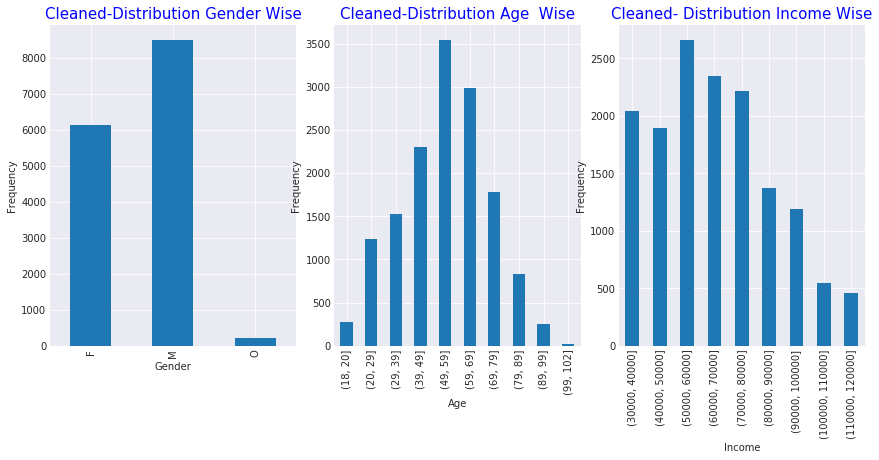

In [76]:
#Creating Subplots for distribution based on Gender,Age and Income for the Newly cleaned Profile data
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# GENDER BASED
cleaned_profile[cleaned_profile.columns[21:]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Cleaned-Distribution Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
cleaned_profile[cleaned_profile.columns[2:12]].sum().plot.bar(ax=ax[1],fontsize=10) 
ax[1].set_title("Cleaned-Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
cleaned_profile[cleaned_profile.columns[12:21]].sum().plot.bar(ax=ax[2],fontsize=10) 
ax[2].set_title("Cleaned- Distribution Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()


We can see the result of the profile charts displayed above after the table has been cleaned.

## Data Cleaning for Transcript

The transcript table consists of value columns which comprises of dictionary values in which the keys are offer id, amount. We need to first extract these keys before we move on to one hot encoding them.

In [86]:
# Functions to create offer id and amount columns from the transcript table.
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_column(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]
    

In [87]:
def clean_transcript(transcript = transcript):
    """
    Cleans the Transcript table by setting one hot encoding values.
    PARAMETERS:
        transcript dataframe
    
    RETURNS:
        Cleaned transcript  dataframe
    
    """
    #
    transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
    transcript['amount'] = transcript.value.apply(create_amount_column)
    
    #  One-hot encode event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat one-hot and df
    new_df = pd.concat([transcript, event], axis=1, sort=False)
    
    # Create and Drop Transaction
    transaction = new_df[new_df["transaction"]==1]
    new_df = new_df.drop(transaction.index)
    
    # Drop
    new_df = new_df.drop(columns = ["event","value", "amount", "transaction"])
    
    return new_df

In [89]:
cleaned_transcript = clean_transcript()
cleaned_transcript.head(10)

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [90]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
person             167581 non-null object
time               167581 non-null int64
offer_id           167581 non-null object
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
dtypes: int64(1), object(2), uint8(3)
memory usage: 5.6+ MB


In [91]:
cleaned_transcript[cleaned_transcript['offer completed']==1].shape

(33579, 6)

<a name="preptable"></a>
# <span style="color:blue"> Preparing Table for Analysis </span>

In order to perform our analysis, we now combine all the tables first before computing anything. The tables cannot be combined directly so we need to perform some operations beforehand.


In [94]:
def concat_tables():
    # Rename column name id with offer_id
    new_portfolio = cleaned_portfolio.rename(columns={"id": "offer_id" })
    
    #  Merge cleaned portfolio and transcript
    final_transcript = cleaned_transcript.merge(new_portfolio[new_portfolio.columns])
    
    # Rename column id with person to merge with transcript
    new_profile = cleaned_profile.rename(columns={"id": "person" })
    
    # Merge profile with transcript on person column
    final_transcript = final_transcript.merge(new_profile[new_profile.columns])
    
    # Rename columns on final transcript.
    columns_names = ['person', 'time', 'offer_id',  'offer completed', 'offer received',' offer viewed', 
 'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational','became_member_on',
 "18-20", "20-29", "29-39", "39-49", "49-59", "59-69", "69-79", "79-89", "89-99", "99-102", "30-40K", "40-50K", "50-60K",
 "60-70K", "70-80K", "80-90K", "90-100K", "100-110K", "110-120K", 
 'F', 'M', 'O']
    final_transcript.columns = columns_names
    
    # Reorganize columns
    cols_order = ['person', 'offer_id', 'time', 
          'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
          'became_member_on',
          "18-20", "20-29", "29-39", "39-49", "49-59", "59-69", "69-79", "79-89", "89-99", "99-102", 'F', 'M', 'O',
          "30-40K", "40-50K", "50-60K", "60-70K", "70-80K", "80-90K", "90-100K", "100-110K", "110-120K", 
          'offer received',' offer viewed', 'offer completed'     
         ]     
    return final_transcript[cols_order]

In [95]:
final_df = concat_tables()

In [96]:
final_df.head()

,person,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K,offer received,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,5,1,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,5,7,5,1,1,0,1,...,0,0,0,0,1,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,5,7,5,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,5,5,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,510,5,5,5,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1


In [100]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 39 columns):
person              148805 non-null object
offer_id            148805 non-null object
time                148805 non-null int64
difficulty          148805 non-null int64
duration            148805 non-null int64
reward              148805 non-null int64
email               148805 non-null int64
mobile              148805 non-null int64
social              148805 non-null int64
web                 148805 non-null int64
bogo                148805 non-null uint8
discount            148805 non-null uint8
informational       148805 non-null uint8
became_member_on    148805 non-null int64
18-20               148805 non-null uint8
20-29               148805 non-null uint8
29-39               148805 non-null uint8
39-49               148805 non-null uint8
49-59               148805 non-null uint8
59-69               148805 non-null uint8
69-79               148805 non-null uint8
79-89

In [97]:
final_df.shape

(148805, 39)

<a name="dataexp"></a>
# <span style="color:blue">Data Exploration </span>

In [99]:
# Total number of records
n_records = len(final_df.index)

# Number of records where offer completed is equal to  1
completed_1 = final_df[final_df["offer completed"] == 1].shape[0]

# Number of records where offer completed is equal to  0
completed_0 = final_df[final_df["offer completed"] == 0].shape[0]

# TODO: Percentage of offer completed
percent_completed = (completed_1 / completed_0) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals that completed offers: {}".format(completed_1))
print("Individuals that did not  complete offers: {}".format(completed_0))
print("Percentage of individuals that completed offers: {0:.2f}%".format(percent_completed))

Total number of records: 148805
Individuals that completed offers: 32444
Individuals that did not  complete offers: 116361
Percentage of individuals that completed offers: 27.88%


### Feature Description 
Lets take a final look at what our column in the dataframe means before answering our Primary questions.   
* person - Customer id
* offer_id - Offer Registration ID of customers
* time - Time since start of the test. The data begins at time t=0 and is displayed in HOURS
* difficulty - Minimum required spend to complete an offer
* duration - Time for offer to be open, in DAYS
* reward - Reward given for completing an offer
* email, mobile, social, web - Channel where offer was offered
* bogo(buy-one-get-one) , informational, discount - types of offer.
* became_member_on - date when customer created an app account
* 18-102 - Age range of Customers
*  F, M , O - Gender of Customers
* 30k- 120k -- Client Income Range
* Offer recieved- Description 
* Offer Viewed- Description
* Offer completed- Target Feature


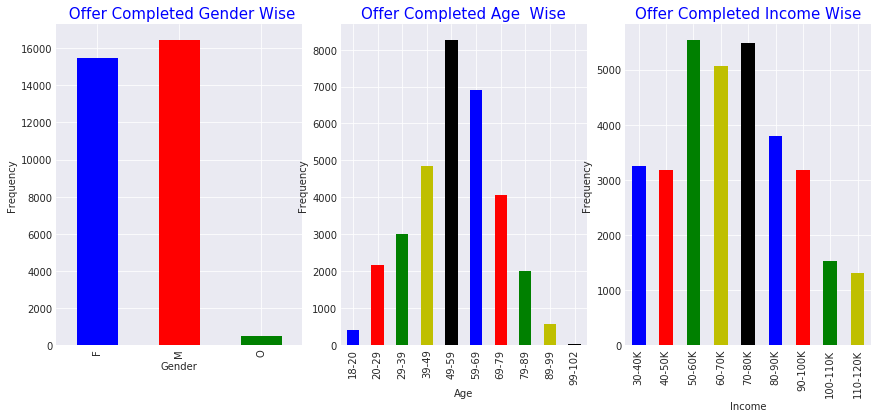

In [121]:
#Creating Subplots for distribution based on Gender,Age and Income for the Newly cleaned Profile data
sns.set_style('darkgrid')
my_color= ['b', 'r', 'g', 'y', 'k']
fig,ax= plt.subplots(1,3,figsize=(12,5))
fig.tight_layout()


# GENDER BASED
final_df[final_df['offer completed']==1][['F','M','O']].sum().plot.bar(ax=ax[0],fontsize=10,color=my_color) 
ax[0].set_title(" Offer Completed Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
age_cols=['18-20','20-29', '29-39', '39-49', '49-59', '59-69', '69-79', '79-89', '89-99','99-102']
final_df[final_df['offer completed']==1][age_cols].sum().plot.bar(ax=ax[1],fontsize=10,color=my_color) 
ax[1].set_title("Offer Completed Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
income_cols=['30-40K', '40-50K', '50-60K', '60-70K','70-80K', '80-90K', '90-100K', '100-110K','110-120K']
final_df[final_df['offer completed']==1][income_cols].sum().plot.bar(ax=ax[2],fontsize=10,color=my_color) 
ax[2].set_title("Offer Completed Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()


From the above charts we can see that the offers that are completed is distributed across Gender, Age and Income.  
1. Based on the Gender, Male category has completed the most offers with frequency abit above 16000 and Female category is close to 16000 and the other category has the minimum with near 1000. So, lets focus on male and female because their frequency is very high as compared to others.
2. Based on the Age group, the age range of 49-59 is most active while completing the offers followed by 59-69 and 39-49 age range.
3. Based on the Income level, people with income ranging fromm 50-80k are the most active ones to complete offers.  
Now, to get a proper idea about the proportion of these distribution we will extract and compute the above data

#### In order to compute the proportion of male or female within the age range of 29 to 69 with income ranging from 30k to 100k who have commpleted the offer, we need their respective data and the total number of participants in the test.    
#### After that we can compute the proportion as:

In [123]:
# Finding  male profile with age 39-69 and age 30k -100k
male_data= profile[(profile['gender']=='M')& (profile['age']>29)& (profile['age']<69) & (profile['income']>30000)\
                   & (profile['income']<100000)]

In [124]:
female_data= profile[(profile['gender']=='F')& (profile['age']>29)& (profile['age']<69) & (profile['income']>30000)\
                   & (profile['income']<100000)]

In [125]:
male_data.shape, female_data.shape

((5565, 5), (3632, 5))

In [127]:
# Appending Both together
merged_mf = male_data.append(female_data)
idx=[]
for person in merged_mf['id']:
    ids= final_df[final_df['person']==person].index.tolist()
    idx.extend(ids)
    

In [130]:
percentage = len(idx) * 100 / final_df.shape[0]
print("The clients who have completed the offer are male or female with age range from 29-69 and incomme range between 30,000- 100,000 and their proportion is {0:.2f}%.".format(percentage))

The clients who have completed the offer are male or female with age range from 29-69 and incomme range between 30,000- 100,000 and their proportion is 62.35%.



# <span style="color:blue">Data preparation for the Model </span>

Before I had speculated that there might be some sort of logical transitions in the operations of the offers which goes like, the customer recieves the offer, views the offer and then completes the offer. But, there does not seem to be any relation between them.

Also as seen in the project description above:    
##### There might be a case that someone using the app might make a purchase through the app without having received an offer or seen an offer.

In [131]:
final_df[final_df["offer completed"] == 1][["offer received", ' offer viewed', 'informational']].sum()


offer received    0
 offer viewed     0
informational     0
dtype: int64

In [132]:
# Since we are interested in offer completion , lets remove other attributes before going on to creaate a model
final_df = final_df.drop(["offer received", ' offer viewed', 'informational', "became_member_on"], axis=1)

In [136]:
# Lets Split the data into feaure and target label
target = final_df['offer completed']
features = final_df.drop('offer completed', axis = 1)
print(" Number of total features: {} ".format(len(features.columns)))

 Number of total features: 34 


In [137]:
features.head()

,person,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,5,5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,510,5,5,5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


## Normalize Numerical Features

In [139]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numericals = features.columns[2:6]

features_log_minmax_transform = pd.DataFrame(data = features)
features_log_minmax_transform[numericals] = scaler.fit_transform(features[numericals])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,person,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.000000,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.008403,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.184874,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.705882,0.25,0.285714,0.5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.714286,0.25,0.285714,0.5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [141]:
features_final = features_log_minmax_transform[features_log_minmax_transform.columns[2:]]
features_final.head()

,time,difficulty,duration,reward,email,mobile,social,web,bogo,discount,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,0.000000,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.008403,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.184874,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.705882,0.25,0.285714,0.5,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.714286,0.25,0.285714,0.5,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


#### Now that we have normalized the numerical values, we can move forward to splitting the data into training and testing samples. 

In [143]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.20, 
                                                    random_state = 42,
                                                   stratify=target)

# Display result after splitting..
print("results of the split\n------")
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

print("\nclass distribution\n------")
print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

results of the split
------
Training set has 119044 samples.
Testing set has 29761 samples.

class distribution
------
y_train class distribution
0    0.781971
1    0.218029
Name: offer completed, dtype: float64
y_test class distribution
0    0.781963
1    0.218037
Name: offer completed, dtype: float64


<a name="evmodel"></a>
# <span style="color:blue">Evaluating Model </span>

### Naive Predictor:

In [144]:
accuracy = accuracy_score(y_train,np.ones(len(y_train)))
fscore = fbeta_score(y_train,np.ones(len(y_train)), beta=0.5)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, fscore: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2180, fscore: 0.2584]


#### Constructing Training and Prediction Pipeline

In [148]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Takes a learning algorithm and uses it to train and predict the samples and returns the performance.
    
    PARAMETERS:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
    RETURNS
        Performance results for the learning algorithm.
    '''
    
    results = {}
    
    #  Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculate the training time
    results['train_time'] = end - start
        
    #  Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    #  Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #  Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #  Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_train'] = f1_score(y_train[:300], predictions_train)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    results['f_test'] = f1_score(y_train[:300], predictions_train)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

#### Initial Model Evaluation

In [151]:
def evaluate(results, accuracy, f1):
    """
    Uses performance of various learning algorithms to produce visualizations.
    
    PARAMETERS:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    RETURNS:
         NONE
    """
   
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#66FFB2','#CCCC00','#9B3510']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

DecisionTreeClassifier trained on 1190 samples.
DecisionTreeClassifier trained on 11904 samples.
DecisionTreeClassifier trained on 119044 samples.
GaussianNB trained on 1190 samples.
GaussianNB trained on 11904 samples.
GaussianNB trained on 119044 samples.
RandomForestClassifier trained on 1190 samples.
RandomForestClassifier trained on 11904 samples.
RandomForestClassifier trained on 119044 samples.


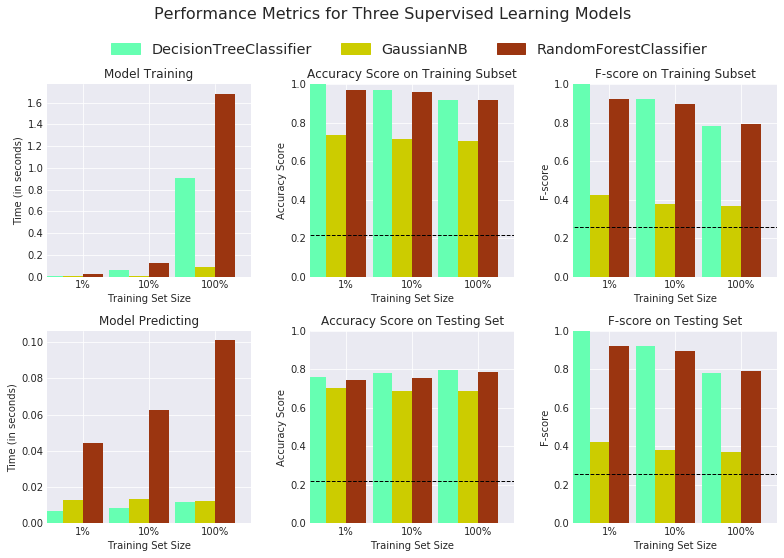

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


#  Initializing the three models
clf_A = DecisionTreeClassifier(random_state =42) #DecisionTree
clf_B = GaussianNB() #NainveBayes
# n_estimators=10 is a default parameter. Necessary for not error message. 
clf_C = RandomForestClassifier(random_state =42, n_estimators=10) #EnsembleMethods 

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 =  int(len(y_train))
samples_10 =  int((samples_100 * 10/100))
samples_1 =   int((samples_100 * 1)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

### Model Tuning

In [153]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#  Initialize the classifier
clf = RandomForestClassifier(random_state =42, n_estimators=20)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'max_features':['auto', 'sqrt'], 'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]} 

#  Make an fbeta_score scoring object using make_scorer()
beta= 0.01
#scorer = make_scorer(fbeta_score, beta=beta)
scorer = make_scorer(precision_score)

#  Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, cv=3, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = beta)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = beta)))

Unoptimized model
------
Accuracy score on testing data: 0.7881
F-score on testing data: 0.5180

Optimized Model
------
Final accuracy score on the testing data: 0.7947
Final F-score on the testing data: 0.6121


In [154]:
# Print a Confusion Matrix
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = conf_mtx = confusion_matrix(y_test, best_predictions).ravel()
con_mtx = np.array([[tp, fn],[fp, tn]])
con_mtx

array([[ 1031,  5458],
       [  653, 22619]])

In [155]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, support, nada = precision_recall_fscore_support(y_test, best_predictions, average='binary', pos_label=1)
print(f"The precision of model is {precision:0.4f}.")
print(f"The recall of model is {recall:0.4f}.")

The precision of model is 0.6122.
The recall of model is 0.1589.


Our goal is a model with better accuracy, for optimization of offer.    
* When we obtain a false Positive and we send offers to those who will not respond to complete the offer, this scenario is worth it for the offer.   
* When we have a false negative and we do not send offers to those who will complete the offer even if they do not receive the offer, this is accepted as they can complete the offer either way.

With better precision, we have better optimization in sending offers to customers.

#### Lets plot a proper confusion matrix to get a visual idea of the results

In [207]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Provided a sklearn confusion matrix, visualizes the matrix.

    PARAMETERS
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Wistia')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

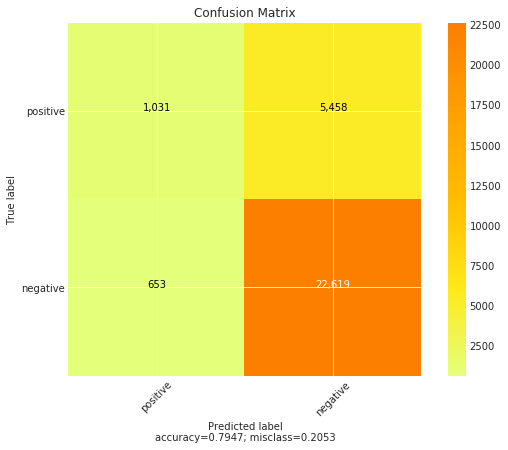

In [208]:
plot_confusion_matrix(cm           = con_mtx, 
                      normalize    = False,
                      target_names = ['positive', 'negative'],
                      title        = "Confusion Matrix")

From the above, confusion matrix shows that we have a low false positive number. which indicates a low number of offer submissions to customers who will not complete the offer.    
Also, False negative is high, So we could stop sending promotions to anyone who would complete the offer without even receiving the offer.

##### Lets view the best classifier that demonstrated this performance


In [209]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

We can see that the Random Forest classifier performed the best among the three classifiers.


---

## Feature Importance 

In [219]:
def feature_plot(importances, X_train, y_train, n=5):
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n]]
    values = importances[indices][:n]

    # Creat the plot
    fig = pl.figure(figsize = (12,6))
    pl.title(f"Normalized Weights for First {n} Predictive Features", fontsize = 16)
    pl.bar(np.arange(n), values, width = 0.6, align="center", color = '#E26741', \
          label = "Feature Weight")
    pl.bar(np.arange(n) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#8E1FEF', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(n), columns)
    #pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper left')
    pl.tight_layout()
    sns.despine(bottom=True, left=True)
    pl.show()

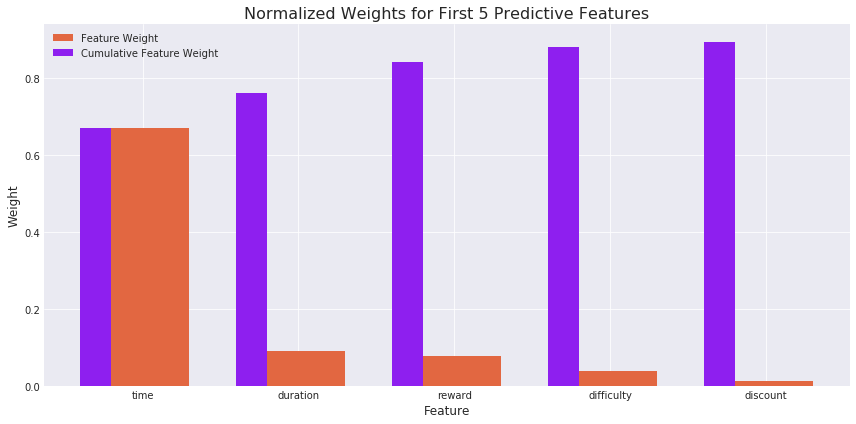

In [220]:
# Import a supervised learning model that has 'feature_importances_'

#  Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf.fit(X_train, y_train)

#  Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train, 5)

##### From the above graph we can see that our supervised model predicted TOP 5 features that would determine if the offer would be completed by the customers.
* Time, Duration , Reward, Difficulty and Discount are the top 5 feature drivers that estimate the offer completion. 
* We need to be aware that  the age range and income of cutomers are not much of a factor since they are divided into ranges but would produce more significant effect on feature drivers had it been taken as a whole. But then again, the features above obtained are primarily realted to the offers which is not the same case for age range and income range. 


<a name="conclusion"></a>
# <span style="color:blue">Conclusion </span>

### Reflections

During this Udacity Capstone project from Starbucks data, we worked with 3 data files in form of json that consists of portfolio data, profile data and transcript data.
We explored the Starbuck’s Dataset which simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.(Buy one get one, Discount and informational).   

* Our focus during this project was on answering the following questions.
1. What is the proportion of client who have completed the offers based on Gender?
2. What is the proportion of client who have completed the offers based on their Age?
3. What is the proportion of client who have completed the offers based on their Income Level?
4. What are the most important features that help drive the offers in customers?
   
   
We began this project by first exploring, cleaning the data, merging the three data before proceeding to find answers to our primarily driven  queries.

##### For (Q1-Q3), the first 3 questions we found out that:   "The clients who have completed the offer are male or female with age range from 29-69 and incomme range between 30,000- 100,000 and their proportion is 62.35%. "   


#### For (Q4) we found out that Time, Duration , Reward, Difficulty and Discount are the top 5 feature drivers that estimate the offer completion with Time being the highest impact driver for features.


#### During the process, Creating a supervised model part was especially challenging. Creating the 3 models(Decision Tree Classifier, Gaussian NB and Random Forest Classifier) to aid in prediction of the feature was a challenging yet intriguing step. We compared the performances of these models and found out that Random Forest Works best in this particular scenario.

---

### Future Improvements

* This data set has more potential to solving many queries and it can be utilized to answer many posed questions related customer interaction based on the Age and income as a whole too.
* Testing additional machine learning models.
* Making a web app.
